# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

### Mejoras Clave Implementadas:

1. Balanceo de Datos:
    - Uso de RandomOverSampler para clases minoritarias
    - Generador de datos mejorado que aplica balanceo automático

2. Arquitectura del Modelo:
    - Más capas densas (1024 y 512 unidades)
    - Activación Swish en lugar de ReLU
    - Regularización adicional con DropConnect y L2
    - Cabezales específicos con diferente regularización

3. Funciones de Pérdida:
    - Implementación de Focal Loss para manejar desbalance
    - Configurable mediante parámetro USE_FOCAL_LOSS

4. Optimización de Umbrales:
    - Cálculo automático de umbrales óptimos por clase
    - Evaluación usando estos umbrales en lugar de 0.5 fijo

5. Callbacks Mejorados:
    - EarlyStopping basado en F1-score
    - ReduceLROnPlateau para ajuste dinámico de tasa de aprendizaje
    - Checkpointing basado en métricas de validación

6. Métricas Extendidas:
    - Seguimiento de recall por clase
    - Cálculo de F1-score durante el entrenamiento

7. Regularización Avanzada:
    - Dropout aumentado
    - Batch Normalization adicional
    - Regularización L2 en cabezal de partes

!pip install tensorflow

In [1]:
# Importar librerías necesarias
# import os
# Configurar para usar CPU si no hay GPU disponible
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # Deshabilitar CUDA
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = no info, 2 = no warnings, 3 = no errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from functools import partial

E0000 00:00:1747003365.382731  370185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747003365.385349  370185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747003365.393189  370185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747003365.393205  370185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747003365.393207  370185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747003365.393208  370185 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30
EPOCHS_FINE_TUNE = 30
LEARNING_RATE_INITIAL = 5e-5
LEARNING_RATE_FINE_TUNE = 5e-6
BASE_MODEL = 'EfficientNetB0'
USE_CLASS_WEIGHTS = True        # Nuevo: Activar balanceo de clases
USE_FOCAL_LOSS = True           # Nuevo: Usar Focal Loss para clases desbalanceadas
USE_CUSTOM_THRESHOLDS = True    # Nuevo: Optimizar umbrales por clase

In [3]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [4]:
# =============================================
# FUNCIONES DE PÉRDIDA MEJORADAS
# =============================================
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal Loss para manejar desbalance de clases"""
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    return -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt + 1e-7)

def get_loss_function(use_focal_loss=True):
    """Devuelve la función de pérdida según configuración"""
    if use_focal_loss:
        return focal_loss
    return 'binary_crossentropy'

In [5]:
# =============================================
# CARGA DE DATOS Y PREPARACIÓN DE ETIQUETAS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar datos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

# Preparar etiquetas
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

# Guardar MultiLabelBinarizer objects para uso posterior
import pickle
with open("mlb_partes.pkl", "wb") as f:
    pickle.dump(mlb_partes, f)
with open("mlb_dannos.pkl", "wb") as f:
    pickle.dump(mlb_dannos, f)
with open("mlb_sugerencias.pkl", "wb") as f:
    pickle.dump(mlb_sugerencias, f)
print("MultiLabelBinarizer objects saved.")

MultiLabelBinarizer objects saved.


In [6]:
class BalancedMultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None,
                 balance_classes=True):
        self.df = df.copy()
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.indices = np.arange(len(self.df))
        
        if balance_classes:
            self._balance_data()
            
        self.on_epoch_end()

    def _balance_data(self):
        y = self.mlb_partes.transform(self.df['partes'])
        temp_df = self.df.copy()
        
        for class_idx in range(y.shape[1]):
            if y[:, class_idx].sum() < 10:
                class_indices = np.where(y[:, class_idx] == 1)[0]
                temp_df = pd.concat([temp_df, self.df.iloc[class_indices]], ignore_index=True)
        
        self.df = temp_df
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            # Asegurar que las etiquetas son listas
            partes = row['partes'] if isinstance(row['partes'], list) else [row['partes']]
            dannos = row['dannos'] if isinstance(row['dannos'], list) else [row['dannos']]
            sugerencias = row['sugerencias'] if isinstance(row['sugerencias'], list) else [row['sugerencias']]
            
            y_partes.append(partes)
            y_dannos.append(dannos)
            y_sugerencias.append(sugerencias)
        
        # Convertir a arrays numpy
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

        """
        Generador de datos mejorado con capacidad de balanceo de clases
        
        Args:
            df: DataFrame con los datos
            img_dir: Directorio base de las imágenes
            mlb_partes: MultiLabelBinarizer para partes
            mlb_dannos: MultiLabelBinarizer para daños
            mlb_sugerencias: MultiLabelBinarizer para sugerencias
            batch_size: Tamaño del batch
            img_size: Tamaño de la imagen (alto, ancho)
            shuffle: Si mezclar los datos después de cada época
            augmentation: Objeto de aumento de datos
            balance_classes: Si aplicar balanceo de clases para partes
        """

In [7]:
class BalancedMultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None,
                 balance_classes=True, workers=1, use_multiprocessing=False, **kwargs):
        """
        Args:
            workers: Número de workers (para compatibilidad, no se usa directamente)
            use_multiprocessing: Si usar multiprocesamiento (para compatibilidad)
            **kwargs: Argumentos adicionales para compatibilidad con super().__init__()
        """
        super().__init__(**kwargs)  # Llama al constructor de la clase padre
        
        self.df = df.copy()
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.balance_classes = balance_classes
        self.workers = workers  # Añadido para compatibilidad
        self.use_multiprocessing = use_multiprocessing  # Añadido para compatibilidad
        
        # Inicializar los índices
        self.indices = np.arange(len(self.df))
        
        if balance_classes:
            self._balance_data()
            
        self.on_epoch_end()

In [8]:
# =============================================
# GENERADOR DE DATOS MEJORADO CON BALANCEO
# =============================================
class BalancedMultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None,
                 balance_classes=True, workers=1, use_multiprocessing=False, **kwargs):
        
        super().__init__(**kwargs)  # Llama al constructor de la clase padre
        
        self.df = df.copy()
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.balance_classes = balance_classes
        self.workers = workers  # Añadido para compatibilidad
        self.use_multiprocessing = use_multiprocessing  # Añadido para compatibilidad
        
        
        # Inicializar los índices
        self.indices = np.arange(len(self.df))
        
        if balance_classes:
            self._balance_data()
            
        self.on_epoch_end()

    def _balance_data(self):
        y = self.mlb_partes.transform(self.df['partes'])
        temp_df = self.df.copy()
        
        for class_idx in range(y.shape[1]):
            if y[:, class_idx].sum() < 10:
                class_indices = np.where(y[:, class_idx] == 1)[0]
                temp_df = pd.concat([temp_df, self.df.iloc[class_indices]], ignore_index=True)
        
        self.df = temp_df
        self.indices = np.arange(len(self.df))  # Actualizar índices después del balanceo

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            # Asegurar que las etiquetas son listas
            partes = row['partes'] if isinstance(row['partes'], list) else [row['partes']]
            dannos = row['dannos'] if isinstance(row['dannos'], list) else [row['dannos']]
            sugerencias = row['sugerencias'] if isinstance(row['sugerencias'], list) else [row['sugerencias']]
            
            y_partes.append(partes)
            y_dannos.append(dannos)
            y_sugerencias.append(sugerencias)
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            np.random.shuffle(self.indices)

# Configurar generadores
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = BalancedMultiLabelDataGenerator(
    train_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias,
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, augmentation=train_datagen,
    balance_classes=True
)

val_generator = BalancedMultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias,
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False,
    balance_classes=False
)

In [9]:
# =============================================
# CONSTRUCCIÓN DEL MODELO MEJORADO
# =============================================
def build_enhanced_model(input_shape, num_partes, num_dannos, num_sugerencias):
    # Cargar modelo base sin el parámetro drop_connect_rate
    base_model = applications.EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Añadir regularización directamente en las capas densas
    x = layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)

    # Capas de salida
    output_partes = layers.Dense(
        num_partes, activation='sigmoid', name='partes'
    )(x)
    output_dannos = layers.Dense(
        num_dannos, activation='sigmoid', name='dannos'
    )(x)
    output_sugerencias = layers.Dense(
        num_sugerencias, activation='sigmoid', name='sugerencias'
    )(x)

    return models.Model(inputs=inputs, outputs=[output_partes, output_dannos, output_sugerencias])

In [10]:
print(f"Número de muestras: {len(train_generator.df)}")
print(f"Ejemplo de batch: {train_generator[0][0].shape}")

Número de muestras: 1226
Ejemplo de batch: (32, 224, 224, 3)


In [11]:
# =============================================
# ENTRENAMIENTO Y EVALUACIÓN - VERSIÓN CORREGIDA
# =============================================
def train_and_evaluate():
    # Construir modelo
    model = build_enhanced_model(
        (*IMG_SIZE, 3),
        len(mlb_partes.classes_),
        len(mlb_dannos.classes_),
        len(mlb_sugerencias.classes_)
    )

    # Configurar callbacks
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

    # Compilar modelo
    model.compile(
        optimizer=Adam(LEARNING_RATE_INITIAL),
        loss={
            'partes': 'binary_crossentropy',
            'dannos': 'binary_crossentropy',
            'sugerencias': 'binary_crossentropy'
        },
        metrics={
            'partes': ['binary_accuracy'],
            'dannos': ['binary_accuracy'],
            'sugerencias': ['binary_accuracy']
        }
    )

    # Entrenamiento inicial
    print("\nEntrenamiento inicial:")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_INITIAL,
        callbacks=callbacks
    )

    # Fine-tuning
    print("\nFine-tuning:")
    model.layers[1].trainable = True
    for layer in model.layers[1].layers[:-30]:
        layer.trainable = False

    # Compilación corregida para fine-tuning
    model.compile(
        optimizer=Adam(LEARNING_RATE_FINE_TUNE),
        loss={
            'partes': get_loss_function(USE_FOCAL_LOSS),
            'dannos': get_loss_function(USE_FOCAL_LOSS),
            'sugerencias': 'binary_crossentropy'
        },
        metrics={
            'partes': ['binary_accuracy'],
            'dannos': ['binary_accuracy'],
            'sugerencias': ['binary_accuracy']
        }
    )

    history_fine = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_FINE_TUNE,
        callbacks=callbacks
    )

    return model

In [12]:
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    print("\nEvaluando en conjunto de prueba...")
    results = model.evaluate(test_generator)
    
    # Asumiendo que el modelo tiene 3 salidas en este orden
    print("\nMétricas de evaluación:")
    print(f"Pérdida total: {results[0]:.4f}")
    print("\nPartes:")
    print(f"  - Pérdida: {results[1]:.4f}")
    print(f"  - Precisión: {results[3]:.4f}")
    print("\nDaños:")
    print(f"  - Pérdida: {results[2]:.4f}")
    print(f"  - Precisión: {results[4]:.4f}")
    print("\nSugerencias:")
    print(f"  - Pérdida: {results[5]:.4f}")
    print(f"  - Precisión: {results[6]:.4f}")
    
    # Generar predicciones
    y_pred = model.predict(test_generator)
    # Aquí puedes añadir más análisis (matrices de confusión, etc.)

In [ ]:
# =============================================
# EJECUCIÓN PRINCIPAL CORREGIDA
# =============================================
# Last Execution 7:15:34 PM
# Execution Time 31m 48.7s
# Overhead Time 105ms
# Render Times
# VS Code Builtin Notebook Output Renderer 199ms

if __name__ == "__main__":
    # Configurar para usar CPU si no hay GPU disponible
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    
    # Entrenar modelo
    model = train_and_evaluate()
    
    # Evaluar en conjunto de prueba
    test_generator = BalancedMultiLabelDataGenerator(
        test_df, 
        img_dir=IMG_DIR,
        mlb_partes=mlb_partes,
        mlb_dannos=mlb_dannos,
        mlb_sugerencias=mlb_sugerencias,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        shuffle=False
    )
    
    print("\nEvaluación en conjunto de prueba:")
    evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)
    
    # Guardar modelo final
    # model.save('modelo_final_v3.h5')
    # print("\nModelo guardado como 'modelo_final_v3.h5'")

    # Guardar modelo final
    model.save('modelo_final_v3.keras')
    print("\nModelo guardado como 'modelo_final_v3.keras'")


Entrenamiento inicial:
Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - dannos_binary_accuracy: 0.5552 - dannos_loss: 0.7631 - loss: 20.5551 - partes_binary_accuracy: 0.5103 - partes_loss: 0.8294 - sugerencias_binary_accuracy: 0.5052 - sugerencias_loss: 0.8736

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 703ms/step - dannos_binary_accuracy: 0.5555 - dannos_loss: 0.7626 - loss: 20.5496 - partes_binary_accuracy: 0.5107 - partes_loss: 0.8287 - sugerencias_binary_accuracy: 0.5058 - sugerencias_loss: 0.8722 - val_dannos_binary_accuracy: 0.4304 - val_dannos_loss: 0.7094 - val_loss: 19.7354 - val_partes_binary_accuracy: 0.5513 - val_partes_loss: 0.6841 - val_sugerencias_binary_accuracy: 0.6870 - val_sugerencias_loss: 0.6393
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - dannos_binary_accuracy: 0.6223 - dannos_loss: 0.6786 - loss: 19.6189 - partes_binary_accuracy: 0.5791 - partes_loss: 0.7240 - sugerencias_binary_accuracy: 0.6588 - sugerencias_loss: 0.6445

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 669ms/step - dannos_binary_accuracy: 0.6225 - dannos_loss: 0.6783 - loss: 19.6147 - partes_binary_accuracy: 0.5796 - partes_loss: 0.7234 - sugerencias_binary_accuracy: 0.6590 - sugerencias_loss: 0.6442 - val_dannos_binary_accuracy: 0.5492 - val_dannos_loss: 0.6853 - val_loss: 19.1338 - val_partes_binary_accuracy: 0.6037 - val_partes_loss: 0.6712 - val_sugerencias_binary_accuracy: 0.7913 - val_sugerencias_loss: 0.5789
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - dannos_binary_accuracy: 0.6507 - dannos_loss: 0.6354 - loss: 18.8983 - partes_binary_accuracy: 0.6526 - partes_loss: 0.6358 - sugerencias_binary_accuracy: 0.7239 - sugerencias_loss: 0.5519

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 673ms/step - dannos_binary_accuracy: 0.6509 - dannos_loss: 0.6352 - loss: 18.8949 - partes_binary_accuracy: 0.6528 - partes_loss: 0.6355 - sugerencias_binary_accuracy: 0.7239 - sugerencias_loss: 0.5519 - val_dannos_binary_accuracy: 0.6358 - val_dannos_loss: 0.6569 - val_loss: 18.5300 - val_partes_binary_accuracy: 0.6625 - val_partes_loss: 0.6525 - val_sugerencias_binary_accuracy: 0.8268 - val_sugerencias_loss: 0.5305
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - dannos_binary_accuracy: 0.6905 - dannos_loss: 0.5867 - loss: 18.2190 - partes_binary_accuracy: 0.7078 - partes_loss: 0.5653 - sugerencias_binary_accuracy: 0.7651 - sugerencias_loss: 0.4854

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 682ms/step - dannos_binary_accuracy: 0.6908 - dannos_loss: 0.5862 - loss: 18.2149 - partes_binary_accuracy: 0.7081 - partes_loss: 0.5650 - sugerencias_binary_accuracy: 0.7652 - sugerencias_loss: 0.4854 - val_dannos_binary_accuracy: 0.7001 - val_dannos_loss: 0.6236 - val_loss: 17.9217 - val_partes_binary_accuracy: 0.7178 - val_partes_loss: 0.6275 - val_sugerencias_binary_accuracy: 0.8366 - val_sugerencias_loss: 0.4832
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - dannos_binary_accuracy: 0.7219 - dannos_loss: 0.5500 - loss: 17.5928 - partes_binary_accuracy: 0.7534 - partes_loss: 0.5098 - sugerencias_binary_accuracy: 0.7842 - sugerencias_loss: 0.4674

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 681ms/step - dannos_binary_accuracy: 0.7220 - dannos_loss: 0.5499 - loss: 17.5895 - partes_binary_accuracy: 0.7537 - partes_loss: 0.5094 - sugerencias_binary_accuracy: 0.7843 - sugerencias_loss: 0.4675 - val_dannos_binary_accuracy: 0.7441 - val_dannos_loss: 0.5921 - val_loss: 17.3191 - val_partes_binary_accuracy: 0.7654 - val_partes_loss: 0.5971 - val_sugerencias_binary_accuracy: 0.8425 - val_sugerencias_loss: 0.4422
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - dannos_binary_accuracy: 0.7516 - dannos_loss: 0.5191 - loss: 16.9793 - partes_binary_accuracy: 0.7984 - partes_loss: 0.4613 - sugerencias_binary_accuracy: 0.8066 - sugerencias_loss: 0.4275

39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 835ms/step - dannos_binary_accuracy: 0.7517 - dannos_loss: 0.5189 - loss: 16.9760 - partes_binary_accuracy: 0.7986 - partes_loss: 0.4610 - sugerencias_binary_accuracy: 0.8067 - sugerencias_loss: 0.4276 - val_dannos_binary_accuracy: 0.7631 - val_dannos_loss: 0.5619 - val_loss: 16.7365 - val_partes_binary_accuracy: 0.8194 - val_partes_loss: 0.5596 - val_sugerencias_binary_accuracy: 0.8465 - val_sugerencias_loss: 0.4166
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - dannos_binary_accuracy: 0.7642 - dannos_loss: 0.5082 - loss: 16.4287 - partes_binary_accuracy: 0.8288 - partes_loss: 0.4194 - sugerencias_binary_accuracy: 0.8182 - sugerencias_loss: 0.4200

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 764ms/step - dannos_binary_accuracy: 0.7642 - dannos_loss: 0.5081 - loss: 16.4254 - partes_binary_accuracy: 0.8289 - partes_loss: 0.4192 - sugerencias_binary_accuracy: 0.8183 - sugerencias_loss: 0.4199 - val_dannos_binary_accuracy: 0.7815 - val_dannos_loss: 0.5302 - val_loss: 16.1586 - val_partes_binary_accuracy: 0.8603 - val_partes_loss: 0.5182 - val_sugerencias_binary_accuracy: 0.8484 - val_sugerencias_loss: 0.3934
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - dannos_binary_accuracy: 0.7748 - dannos_loss: 0.4878 - loss: 15.8720 - partes_binary_accuracy: 0.8532 - partes_loss: 0.3869 - sugerencias_binary_accuracy: 0.8334 - sugerencias_loss: 0.3869

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 787ms/step - dannos_binary_accuracy: 0.7747 - dannos_loss: 0.4877 - loss: 15.8687 - partes_binary_accuracy: 0.8533 - partes_loss: 0.3867 - sugerencias_binary_accuracy: 0.8335 - sugerencias_loss: 0.3869 - val_dannos_binary_accuracy: 0.7986 - val_dannos_loss: 0.4999 - val_loss: 15.6000 - val_partes_binary_accuracy: 0.8917 - val_partes_loss: 0.4750 - val_sugerencias_binary_accuracy: 0.8504 - val_sugerencias_loss: 0.3793
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - dannos_binary_accuracy: 0.7831 - dannos_loss: 0.4627 - loss: 15.3479 - partes_binary_accuracy: 0.8771 - partes_loss: 0.3578 - sugerencias_binary_accuracy: 0.8379 - sugerencias_loss: 0.3930

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 683ms/step - dannos_binary_accuracy: 0.7830 - dannos_loss: 0.4629 - loss: 15.3449 - partes_binary_accuracy: 0.8771 - partes_loss: 0.3576 - sugerencias_binary_accuracy: 0.8380 - sugerencias_loss: 0.3928 - val_dannos_binary_accuracy: 0.8117 - val_dannos_loss: 0.4689 - val_loss: 15.0384 - val_partes_binary_accuracy: 0.9166 - val_partes_loss: 0.4296 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3551
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - dannos_binary_accuracy: 0.7918 - dannos_loss: 0.4560 - loss: 14.8036 - partes_binary_accuracy: 0.8922 - partes_loss: 0.3335 - sugerencias_binary_accuracy: 0.8571 - sugerencias_loss: 0.3397

39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 839ms/step - dannos_binary_accuracy: 0.7919 - dannos_loss: 0.4559 - loss: 14.8013 - partes_binary_accuracy: 0.8923 - partes_loss: 0.3334 - sugerencias_binary_accuracy: 0.8568 - sugerencias_loss: 0.3404 - val_dannos_binary_accuracy: 0.8150 - val_dannos_loss: 0.4499 - val_loss: 14.5208 - val_partes_binary_accuracy: 0.9305 - val_partes_loss: 0.3915 - val_sugerencias_binary_accuracy: 0.8661 - val_sugerencias_loss: 0.3455
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - dannos_binary_accuracy: 0.7940 - dannos_loss: 0.4421 - loss: 14.3272 - partes_binary_accuracy: 0.9036 - partes_loss: 0.3148 - sugerencias_binary_accuracy: 0.8588 - sugerencias_loss: 0.3437

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 749ms/step - dannos_binary_accuracy: 0.7941 - dannos_loss: 0.4420 - loss: 14.3246 - partes_binary_accuracy: 0.9037 - partes_loss: 0.3147 - sugerencias_binary_accuracy: 0.8587 - sugerencias_loss: 0.3437 - val_dannos_binary_accuracy: 0.8235 - val_dannos_loss: 0.4335 - val_loss: 14.0234 - val_partes_binary_accuracy: 0.9377 - val_partes_loss: 0.3580 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3374
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_binary_accuracy: 0.8083 - dannos_loss: 0.4336 - loss: 13.8498 - partes_binary_accuracy: 0.9163 - partes_loss: 0.2930 - sugerencias_binary_accuracy: 0.8674 - sugerencias_loss: 0.3335

39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 729ms/step - dannos_binary_accuracy: 0.8082 - dannos_loss: 0.4335 - loss: 13.8472 - partes_binary_accuracy: 0.9163 - partes_loss: 0.2930 - sugerencias_binary_accuracy: 0.8671 - sugerencias_loss: 0.3337 - val_dannos_binary_accuracy: 0.8281 - val_dannos_loss: 0.4215 - val_loss: 13.5507 - val_partes_binary_accuracy: 0.9427 - val_partes_loss: 0.3310 - val_sugerencias_binary_accuracy: 0.8701 - val_sugerencias_loss: 0.3314
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - dannos_binary_accuracy: 0.8178 - dannos_loss: 0.4086 - loss: 13.4355 - partes_binary_accuracy: 0.9210 - partes_loss: 0.2806 - sugerencias_binary_accuracy: 0.8490 - sugerencias_loss: 0.3662

39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 835ms/step - dannos_binary_accuracy: 0.8176 - dannos_loss: 0.4090 - loss: 13.4323 - partes_binary_accuracy: 0.9210 - partes_loss: 0.2805 - sugerencias_binary_accuracy: 0.8491 - sugerencias_loss: 0.3656 - val_dannos_binary_accuracy: 0.8287 - val_dannos_loss: 0.4109 - val_loss: 13.0984 - val_partes_binary_accuracy: 0.9452 - val_partes_loss: 0.3069 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3304
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - dannos_binary_accuracy: 0.8086 - dannos_loss: 0.4199 - loss: 12.9878 - partes_binary_accuracy: 0.9263 - partes_loss: 0.2697 - sugerencias_binary_accuracy: 0.8618 - sugerencias_loss: 0.3469

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 743ms/step - dannos_binary_accuracy: 0.8085 - dannos_loss: 0.4201 - loss: 12.9854 - partes_binary_accuracy: 0.9263 - partes_loss: 0.2697 - sugerencias_binary_accuracy: 0.8617 - sugerencias_loss: 0.3469 - val_dannos_binary_accuracy: 0.8327 - val_dannos_loss: 0.4024 - val_loss: 12.6539 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.2839 - val_sugerencias_binary_accuracy: 0.8681 - val_sugerencias_loss: 0.3227
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - dannos_binary_accuracy: 0.8085 - dannos_loss: 0.4247 - loss: 12.5570 - partes_binary_accuracy: 0.9311 - partes_loss: 0.2583 - sugerencias_binary_accuracy: 0.8580 - sugerencias_loss: 0.3245

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 734ms/step - dannos_binary_accuracy: 0.8085 - dannos_loss: 0.4246 - loss: 12.5545 - partes_binary_accuracy: 0.9312 - partes_loss: 0.2582 - sugerencias_binary_accuracy: 0.8582 - sugerencias_loss: 0.3245 - val_dannos_binary_accuracy: 0.8333 - val_dannos_loss: 0.3952 - val_loss: 12.2374 - val_partes_binary_accuracy: 0.9495 - val_partes_loss: 0.2666 - val_sugerencias_binary_accuracy: 0.8661 - val_sugerencias_loss: 0.3231
Epoch 16/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - dannos_binary_accuracy: 0.8180 - dannos_loss: 0.4103 - loss: 12.1387 - partes_binary_accuracy: 0.9339 - partes_loss: 0.2496 - sugerencias_binary_accuracy: 0.8704 - sugerencias_loss: 0.3194

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 824ms/step - dannos_binary_accuracy: 0.8180 - dannos_loss: 0.4103 - loss: 12.1366 - partes_binary_accuracy: 0.9339 - partes_loss: 0.2495 - sugerencias_binary_accuracy: 0.8704 - sugerencias_loss: 0.3195 - val_dannos_binary_accuracy: 0.8373 - val_dannos_loss: 0.3900 - val_loss: 11.8369 - val_partes_binary_accuracy: 0.9496 - val_partes_loss: 0.2541 - val_sugerencias_binary_accuracy: 0.8681 - val_sugerencias_loss: 0.3215
Epoch 17/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - dannos_binary_accuracy: 0.8142 - dannos_loss: 0.4111 - loss: 11.7608 - partes_binary_accuracy: 0.9336 - partes_loss: 0.2477 - sugerencias_binary_accuracy: 0.8705 - sugerencias_loss: 0.3398

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 758ms/step - dannos_binary_accuracy: 0.8143 - dannos_loss: 0.4111 - loss: 11.7582 - partes_binary_accuracy: 0.9337 - partes_loss: 0.2476 - sugerencias_binary_accuracy: 0.8705 - sugerencias_loss: 0.3394 - val_dannos_binary_accuracy: 0.8373 - val_dannos_loss: 0.3854 - val_loss: 11.4562 - val_partes_binary_accuracy: 0.9502 - val_partes_loss: 0.2469 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3210
Epoch 18/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - dannos_binary_accuracy: 0.8120 - dannos_loss: 0.4135 - loss: 11.3969 - partes_binary_accuracy: 0.9383 - partes_loss: 0.2386 - sugerencias_binary_accuracy: 0.8614 - sugerencias_loss: 0.3291

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 739ms/step - dannos_binary_accuracy: 0.8122 - dannos_loss: 0.4133 - loss: 11.3942 - partes_binary_accuracy: 0.9383 - partes_loss: 0.2385 - sugerencias_binary_accuracy: 0.8614 - sugerencias_loss: 0.3289 - val_dannos_binary_accuracy: 0.8366 - val_dannos_loss: 0.3822 - val_loss: 11.0860 - val_partes_binary_accuracy: 0.9500 - val_partes_loss: 0.2394 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3180
Epoch 19/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - dannos_binary_accuracy: 0.8180 - dannos_loss: 0.4038 - loss: 11.0141 - partes_binary_accuracy: 0.9406 - partes_loss: 0.2315 - sugerencias_binary_accuracy: 0.8577 - sugerencias_loss: 0.3192

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 824ms/step - dannos_binary_accuracy: 0.8181 - dannos_loss: 0.4036 - loss: 11.0114 - partes_binary_accuracy: 0.9406 - partes_loss: 0.2315 - sugerencias_binary_accuracy: 0.8580 - sugerencias_loss: 0.3189 - val_dannos_binary_accuracy: 0.8360 - val_dannos_loss: 0.3803 - val_loss: 10.7319 - val_partes_binary_accuracy: 0.9504 - val_partes_loss: 0.2315 - val_sugerencias_binary_accuracy: 0.8642 - val_sugerencias_loss: 0.3184
Epoch 20/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - dannos_binary_accuracy: 0.8281 - dannos_loss: 0.3937 - loss: 10.6683 - partes_binary_accuracy: 0.9435 - partes_loss: 0.2224 - sugerencias_binary_accuracy: 0.8628 - sugerencias_loss: 0.3313

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 733ms/step - dannos_binary_accuracy: 0.8281 - dannos_loss: 0.3937 - loss: 10.6656 - partes_binary_accuracy: 0.9435 - partes_loss: 0.2224 - sugerencias_binary_accuracy: 0.8631 - sugerencias_loss: 0.3307 - val_dannos_binary_accuracy: 0.8353 - val_dannos_loss: 0.3780 - val_loss: 10.3897 - val_partes_binary_accuracy: 0.9509 - val_partes_loss: 0.2242 - val_sugerencias_binary_accuracy: 0.8760 - val_sugerencias_loss: 0.3200
Epoch 21/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - dannos_binary_accuracy: 0.8162 - dannos_loss: 0.3946 - loss: 10.3234 - partes_binary_accuracy: 0.9431 - partes_loss: 0.2195 - sugerencias_binary_accuracy: 0.8690 - sugerencias_loss: 0.3203

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 816ms/step - dannos_binary_accuracy: 0.8162 - dannos_loss: 0.3946 - loss: 10.3213 - partes_binary_accuracy: 0.9430 - partes_loss: 0.2195 - sugerencias_binary_accuracy: 0.8691 - sugerencias_loss: 0.3201 - val_dannos_binary_accuracy: 0.8379 - val_dannos_loss: 0.3773 - val_loss: 10.0602 - val_partes_binary_accuracy: 0.9514 - val_partes_loss: 0.2185 - val_sugerencias_binary_accuracy: 0.8740 - val_sugerencias_loss: 0.3206
Epoch 22/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - dannos_binary_accuracy: 0.8230 - dannos_loss: 0.3895 - loss: 9.9819 - partes_binary_accuracy: 0.9423 - partes_loss: 0.2167 - sugerencias_binary_accuracy: 0.8791 - sugerencias_loss: 0.3071

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 683ms/step - dannos_binary_accuracy: 0.8232 - dannos_loss: 0.3893 - loss: 9.9794 - partes_binary_accuracy: 0.9423 - partes_loss: 0.2166 - sugerencias_binary_accuracy: 0.8792 - sugerencias_loss: 0.3068 - val_dannos_binary_accuracy: 0.8379 - val_dannos_loss: 0.3769 - val_loss: 9.7480 - val_partes_binary_accuracy: 0.9514 - val_partes_loss: 0.2174 - val_sugerencias_binary_accuracy: 0.8740 - val_sugerencias_loss: 0.3227
Epoch 23/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - dannos_binary_accuracy: 0.8385 - dannos_loss: 0.3636 - loss: 9.6058 - partes_binary_accuracy: 0.9434 - partes_loss: 0.2115 - sugerencias_binary_accuracy: 0.8829 - sugerencias_loss: 0.2734

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 808ms/step - dannos_binary_accuracy: 0.8383 - dannos_loss: 0.3640 - loss: 9.6044 - partes_binary_accuracy: 0.9434 - partes_loss: 0.2115 - sugerencias_binary_accuracy: 0.8830 - sugerencias_loss: 0.2735 - val_dannos_binary_accuracy: 0.8360 - val_dannos_loss: 0.3739 - val_loss: 9.4306 - val_partes_binary_accuracy: 0.9515 - val_partes_loss: 0.2104 - val_sugerencias_binary_accuracy: 0.8720 - val_sugerencias_loss: 0.3179
Epoch 24/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - dannos_binary_accuracy: 0.8310 - dannos_loss: 0.3748 - loss: 9.3561 - partes_binary_accuracy: 0.9458 - partes_loss: 0.2070 - sugerencias_binary_accuracy: 0.8699 - sugerencias_loss: 0.3155

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 819ms/step - dannos_binary_accuracy: 0.8309 - dannos_loss: 0.3748 - loss: 9.3543 - partes_binary_accuracy: 0.9458 - partes_loss: 0.2071 - sugerencias_binary_accuracy: 0.8699 - sugerencias_loss: 0.3154 - val_dannos_binary_accuracy: 0.8406 - val_dannos_loss: 0.3738 - val_loss: 9.1359 - val_partes_binary_accuracy: 0.9519 - val_partes_loss: 0.2066 - val_sugerencias_binary_accuracy: 0.8720 - val_sugerencias_loss: 0.3194
Epoch 25/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - dannos_binary_accuracy: 0.8358 - dannos_loss: 0.3694 - loss: 9.0199 - partes_binary_accuracy: 0.9459 - partes_loss: 0.2039 - sugerencias_binary_accuracy: 0.8834 - sugerencias_loss: 0.2789

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 813ms/step - dannos_binary_accuracy: 0.8357 - dannos_loss: 0.3694 - loss: 9.0185 - partes_binary_accuracy: 0.9459 - partes_loss: 0.2039 - sugerencias_binary_accuracy: 0.8834 - sugerencias_loss: 0.2791 - val_dannos_binary_accuracy: 0.8406 - val_dannos_loss: 0.3713 - val_loss: 8.8480 - val_partes_binary_accuracy: 0.9515 - val_partes_loss: 0.2055 - val_sugerencias_binary_accuracy: 0.8720 - val_sugerencias_loss: 0.3176
Epoch 26/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - dannos_binary_accuracy: 0.8236 - dannos_loss: 0.3826 - loss: 8.7418 - partes_binary_accuracy: 0.9457 - partes_loss: 0.2042 - sugerencias_binary_accuracy: 0.8813 - sugerencias_loss: 0.2785

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 661ms/step - dannos_binary_accuracy: 0.8238 - dannos_loss: 0.3823 - loss: 8.7399 - partes_binary_accuracy: 0.9457 - partes_loss: 0.2042 - sugerencias_binary_accuracy: 0.8814 - sugerencias_loss: 0.2784 - val_dannos_binary_accuracy: 0.8386 - val_dannos_loss: 0.3719 - val_loss: 8.5771 - val_partes_binary_accuracy: 0.9515 - val_partes_loss: 0.2038 - val_sugerencias_binary_accuracy: 0.8720 - val_sugerencias_loss: 0.3204
Epoch 27/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - dannos_binary_accuracy: 0.8339 - dannos_loss: 0.3656 - loss: 8.4702 - partes_binary_accuracy: 0.9442 - partes_loss: 0.2035 - sugerencias_binary_accuracy: 0.8895 - sugerencias_loss: 0.2843

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 796ms/step - dannos_binary_accuracy: 0.8340 - dannos_loss: 0.3655 - loss: 8.4685 - partes_binary_accuracy: 0.9442 - partes_loss: 0.2034 - sugerencias_binary_accuracy: 0.8893 - sugerencias_loss: 0.2843 - val_dannos_binary_accuracy: 0.8366 - val_dannos_loss: 0.3698 - val_loss: 8.3084 - val_partes_binary_accuracy: 0.9521 - val_partes_loss: 0.2005 - val_sugerencias_binary_accuracy: 0.8740 - val_sugerencias_loss: 0.3209
Epoch 28/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - dannos_binary_accuracy: 0.8476 - dannos_loss: 0.3538 - loss: 8.1937 - partes_binary_accuracy: 0.9472 - partes_loss: 0.1909 - sugerencias_binary_accuracy: 0.8714 - sugerencias_loss: 0.3046

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 799ms/step - dannos_binary_accuracy: 0.8473 - dannos_loss: 0.3541 - loss: 8.1924 - partes_binary_accuracy: 0.9471 - partes_loss: 0.1910 - sugerencias_binary_accuracy: 0.8715 - sugerencias_loss: 0.3045 - val_dannos_binary_accuracy: 0.8386 - val_dannos_loss: 0.3726 - val_loss: 8.0597 - val_partes_binary_accuracy: 0.9522 - val_partes_loss: 0.1996 - val_sugerencias_binary_accuracy: 0.8681 - val_sugerencias_loss: 0.3243
Epoch 29/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - dannos_binary_accuracy: 0.8303 - dannos_loss: 0.3670 - loss: 7.9294 - partes_binary_accuracy: 0.9462 - partes_loss: 0.1978 - sugerencias_binary_accuracy: 0.8967 - sugerencias_loss: 0.2632

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 739ms/step - dannos_binary_accuracy: 0.8304 - dannos_loss: 0.3669 - loss: 7.9279 - partes_binary_accuracy: 0.9462 - partes_loss: 0.1978 - sugerencias_binary_accuracy: 0.8967 - sugerencias_loss: 0.2633 - val_dannos_binary_accuracy: 0.8379 - val_dannos_loss: 0.3724 - val_loss: 7.8106 - val_partes_binary_accuracy: 0.9519 - val_partes_loss: 0.1966 - val_sugerencias_binary_accuracy: 0.8720 - val_sugerencias_loss: 0.3236
Epoch 30/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - dannos_binary_accuracy: 0.8409 - dannos_loss: 0.3662 - loss: 7.6660 - partes_binary_accuracy: 0.9496 - partes_loss: 0.1845 - sugerencias_binary_accuracy: 0.8978 - sugerencias_loss: 0.2546

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 693ms/step - dannos_binary_accuracy: 0.8408 - dannos_loss: 0.3662 - loss: 7.6646 - partes_binary_accuracy: 0.9495 - partes_loss: 0.1846 - sugerencias_binary_accuracy: 0.8979 - sugerencias_loss: 0.2545 - val_dannos_binary_accuracy: 0.8373 - val_dannos_loss: 0.3694 - val_loss: 7.5557 - val_partes_binary_accuracy: 0.9525 - val_partes_loss: 0.1918 - val_sugerencias_binary_accuracy: 0.8780 - val_sugerencias_loss: 0.3138

Fine-tuning:
Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - dannos_binary_accuracy: 0.8177 - dannos_loss: 0.0333 - loss: 7.0571 - partes_binary_accuracy: 0.9430 - partes_loss: 0.0159 - sugerencias_binary_accuracy: 0.8622 - sugerencias_loss: 0.3341

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 944ms/step - dannos_binary_accuracy: 0.8179 - dannos_loss: 0.0333 - loss: 7.0567 - partes_binary_accuracy: 0.9430 - partes_loss: 0.0159 - sugerencias_binary_accuracy: 0.8622 - sugerencias_loss: 0.3339 - val_dannos_binary_accuracy: 0.8327 - val_dannos_loss: 0.0331 - val_loss: 7.0113 - val_partes_binary_accuracy: 0.9515 - val_partes_loss: 0.0127 - val_sugerencias_binary_accuracy: 0.8740 - val_sugerencias_loss: 0.3145
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - dannos_binary_accuracy: 0.8259 - dannos_loss: 0.0343 - loss: 7.0221 - partes_binary_accuracy: 0.9442 - partes_loss: 0.0154 - sugerencias_binary_accuracy: 0.8615 - sugerencias_loss: 0.3280

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 763ms/step - dannos_binary_accuracy: 0.8259 - dannos_loss: 0.0343 - loss: 7.0221 - partes_binary_accuracy: 0.9442 - partes_loss: 0.0154 - sugerencias_binary_accuracy: 0.8614 - sugerencias_loss: 0.3281 - val_dannos_binary_accuracy: 0.8294 - val_dannos_loss: 0.0331 - val_loss: 6.9864 - val_partes_binary_accuracy: 0.9506 - val_partes_loss: 0.0122 - val_sugerencias_binary_accuracy: 0.8661 - val_sugerencias_loss: 0.3190
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - dannos_binary_accuracy: 0.8223 - dannos_loss: 0.0330 - loss: 6.9624 - partes_binary_accuracy: 0.9456 - partes_loss: 0.0152 - sugerencias_binary_accuracy: 0.8799 - sugerencias_loss: 0.2995

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 915ms/step - dannos_binary_accuracy: 0.8223 - dannos_loss: 0.0331 - loss: 6.9626 - partes_binary_accuracy: 0.9456 - partes_loss: 0.0152 - sugerencias_binary_accuracy: 0.8797 - sugerencias_loss: 0.2998 - val_dannos_binary_accuracy: 0.8320 - val_dannos_loss: 0.0333 - val_loss: 6.9628 - val_partes_binary_accuracy: 0.9510 - val_partes_loss: 0.0120 - val_sugerencias_binary_accuracy: 0.8681 - val_sugerencias_loss: 0.3241
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - dannos_binary_accuracy: 0.8213 - dannos_loss: 0.0344 - loss: 6.9433 - partes_binary_accuracy: 0.9442 - partes_loss: 0.0148 - sugerencias_binary_accuracy: 0.8681 - sugerencias_loss: 0.3066

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 863ms/step - dannos_binary_accuracy: 0.8214 - dannos_loss: 0.0344 - loss: 6.9432 - partes_binary_accuracy: 0.9442 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8681 - sugerencias_loss: 0.3067 - val_dannos_binary_accuracy: 0.8274 - val_dannos_loss: 0.0333 - val_loss: 6.9389 - val_partes_binary_accuracy: 0.9513 - val_partes_loss: 0.0118 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3287
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - dannos_binary_accuracy: 0.8174 - dannos_loss: 0.0333 - loss: 6.9438 - partes_binary_accuracy: 0.9438 - partes_loss: 0.0158 - sugerencias_binary_accuracy: 0.8617 - sugerencias_loss: 0.3366

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - dannos_binary_accuracy: 0.8174 - dannos_loss: 0.0334 - loss: 6.9434 - partes_binary_accuracy: 0.9438 - partes_loss: 0.0158 - sugerencias_binary_accuracy: 0.8618 - sugerencias_loss: 0.3363 - val_dannos_binary_accuracy: 0.8222 - val_dannos_loss: 0.0334 - val_loss: 6.9146 - val_partes_binary_accuracy: 0.9510 - val_partes_loss: 0.0117 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3329
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - dannos_binary_accuracy: 0.8263 - dannos_loss: 0.0336 - loss: 6.8710 - partes_binary_accuracy: 0.9439 - partes_loss: 0.0155 - sugerencias_binary_accuracy: 0.8744 - sugerencias_loss: 0.2906

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 925ms/step - dannos_binary_accuracy: 0.8263 - dannos_loss: 0.0336 - loss: 6.8712 - partes_binary_accuracy: 0.9439 - partes_loss: 0.0155 - sugerencias_binary_accuracy: 0.8743 - sugerencias_loss: 0.2909 - val_dannos_binary_accuracy: 0.8222 - val_dannos_loss: 0.0333 - val_loss: 6.8888 - val_partes_binary_accuracy: 0.9506 - val_partes_loss: 0.0116 - val_sugerencias_binary_accuracy: 0.8583 - val_sugerencias_loss: 0.3354
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - dannos_binary_accuracy: 0.8246 - dannos_loss: 0.0336 - loss: 6.8555 - partes_binary_accuracy: 0.9450 - partes_loss: 0.0154 - sugerencias_binary_accuracy: 0.8661 - sugerencias_loss: 0.2996

39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 907ms/step - dannos_binary_accuracy: 0.8247 - dannos_loss: 0.0336 - loss: 6.8551 - partes_binary_accuracy: 0.9450 - partes_loss: 0.0154 - sugerencias_binary_accuracy: 0.8664 - sugerencias_loss: 0.2994 - val_dannos_binary_accuracy: 0.8182 - val_dannos_loss: 0.0333 - val_loss: 6.8628 - val_partes_binary_accuracy: 0.9502 - val_partes_loss: 0.0116 - val_sugerencias_binary_accuracy: 0.8524 - val_sugerencias_loss: 0.3377
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - dannos_binary_accuracy: 0.8234 - dannos_loss: 0.0334 - loss: 6.8595 - partes_binary_accuracy: 0.9426 - partes_loss: 0.0157 - sugerencias_binary_accuracy: 0.8613 - sugerencias_loss: 0.3369

39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 817ms/step - dannos_binary_accuracy: 0.8234 - dannos_loss: 0.0334 - loss: 6.8588 - partes_binary_accuracy: 0.9427 - partes_loss: 0.0156 - sugerencias_binary_accuracy: 0.8615 - sugerencias_loss: 0.3364 - val_dannos_binary_accuracy: 0.8176 - val_dannos_loss: 0.0332 - val_loss: 6.8356 - val_partes_binary_accuracy: 0.9495 - val_partes_loss: 0.0115 - val_sugerencias_binary_accuracy: 0.8484 - val_sugerencias_loss: 0.3388
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - dannos_binary_accuracy: 0.8282 - dannos_loss: 0.0324 - loss: 6.7869 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0156 - sugerencias_binary_accuracy: 0.8746 - sugerencias_loss: 0.3001

39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 892ms/step - dannos_binary_accuracy: 0.8283 - dannos_loss: 0.0324 - loss: 6.7868 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0155 - sugerencias_binary_accuracy: 0.8747 - sugerencias_loss: 0.3003 - val_dannos_binary_accuracy: 0.8169 - val_dannos_loss: 0.0330 - val_loss: 6.8085 - val_partes_binary_accuracy: 0.9492 - val_partes_loss: 0.0115 - val_sugerencias_binary_accuracy: 0.8524 - val_sugerencias_loss: 0.3399
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - dannos_binary_accuracy: 0.8293 - dannos_loss: 0.0319 - loss: 6.7477 - partes_binary_accuracy: 0.9436 - partes_loss: 0.0156 - sugerencias_binary_accuracy: 0.8891 - sugerencias_loss: 0.2828

39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 847ms/step - dannos_binary_accuracy: 0.8293 - dannos_loss: 0.0319 - loss: 6.7474 - partes_binary_accuracy: 0.9436 - partes_loss: 0.0156 - sugerencias_binary_accuracy: 0.8891 - sugerencias_loss: 0.2827 - val_dannos_binary_accuracy: 0.8156 - val_dannos_loss: 0.0328 - val_loss: 6.7799 - val_partes_binary_accuracy: 0.9492 - val_partes_loss: 0.0114 - val_sugerencias_binary_accuracy: 0.8504 - val_sugerencias_loss: 0.3396
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - dannos_binary_accuracy: 0.8262 - dannos_loss: 0.0327 - loss: 6.7406 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8779 - sugerencias_loss: 0.3023

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 868ms/step - dannos_binary_accuracy: 0.8262 - dannos_loss: 0.0327 - loss: 6.7403 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8781 - sugerencias_loss: 0.3021 - val_dannos_binary_accuracy: 0.8176 - val_dannos_loss: 0.0327 - val_loss: 6.7519 - val_partes_binary_accuracy: 0.9491 - val_partes_loss: 0.0114 - val_sugerencias_binary_accuracy: 0.8524 - val_sugerencias_loss: 0.3396
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - dannos_binary_accuracy: 0.8170 - dannos_loss: 0.0342 - loss: 6.7228 - partes_binary_accuracy: 0.9439 - partes_loss: 0.0150 - sugerencias_binary_accuracy: 0.8720 - sugerencias_loss: 0.3118

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 772ms/step - dannos_binary_accuracy: 0.8171 - dannos_loss: 0.0342 - loss: 6.7219 - partes_binary_accuracy: 0.9439 - partes_loss: 0.0150 - sugerencias_binary_accuracy: 0.8724 - sugerencias_loss: 0.3112 - val_dannos_binary_accuracy: 0.8169 - val_dannos_loss: 0.0325 - val_loss: 6.7224 - val_partes_binary_accuracy: 0.9492 - val_partes_loss: 0.0114 - val_sugerencias_binary_accuracy: 0.8543 - val_sugerencias_loss: 0.3381
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - dannos_binary_accuracy: 0.8289 - dannos_loss: 0.0329 - loss: 6.6719 - partes_binary_accuracy: 0.9431 - partes_loss: 0.0155 - sugerencias_binary_accuracy: 0.8863 - sugerencias_loss: 0.2945

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 916ms/step - dannos_binary_accuracy: 0.8289 - dannos_loss: 0.0329 - loss: 6.6717 - partes_binary_accuracy: 0.9431 - partes_loss: 0.0155 - sugerencias_binary_accuracy: 0.8862 - sugerencias_loss: 0.2945 - val_dannos_binary_accuracy: 0.8182 - val_dannos_loss: 0.0324 - val_loss: 6.6942 - val_partes_binary_accuracy: 0.9491 - val_partes_loss: 0.0113 - val_sugerencias_binary_accuracy: 0.8543 - val_sugerencias_loss: 0.3379
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - dannos_binary_accuracy: 0.8237 - dannos_loss: 0.0321 - loss: 6.6333 - partes_binary_accuracy: 0.9438 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8828 - sugerencias_loss: 0.2813

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 751ms/step - dannos_binary_accuracy: 0.8237 - dannos_loss: 0.0321 - loss: 6.6331 - partes_binary_accuracy: 0.9439 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8828 - sugerencias_loss: 0.2813 - val_dannos_binary_accuracy: 0.8156 - val_dannos_loss: 0.0324 - val_loss: 6.6657 - val_partes_binary_accuracy: 0.9484 - val_partes_loss: 0.0113 - val_sugerencias_binary_accuracy: 0.8563 - val_sugerencias_loss: 0.3372
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - dannos_binary_accuracy: 0.8281 - dannos_loss: 0.0313 - loss: 6.5885 - partes_binary_accuracy: 0.9451 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.8907 - sugerencias_loss: 0.2643

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 878ms/step - dannos_binary_accuracy: 0.8281 - dannos_loss: 0.0313 - loss: 6.5884 - partes_binary_accuracy: 0.9451 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.8906 - sugerencias_loss: 0.2643 - val_dannos_binary_accuracy: 0.8156 - val_dannos_loss: 0.0322 - val_loss: 6.6353 - val_partes_binary_accuracy: 0.9481 - val_partes_loss: 0.0113 - val_sugerencias_binary_accuracy: 0.8583 - val_sugerencias_loss: 0.3347
Epoch 16/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - dannos_binary_accuracy: 0.8284 - dannos_loss: 0.0306 - loss: 6.5501 - partes_binary_accuracy: 0.9444 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8992 - sugerencias_loss: 0.2504

39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 903ms/step - dannos_binary_accuracy: 0.8284 - dannos_loss: 0.0306 - loss: 6.5504 - partes_binary_accuracy: 0.9444 - partes_loss: 0.0149 - sugerencias_binary_accuracy: 0.8990 - sugerencias_loss: 0.2509 - val_dannos_binary_accuracy: 0.8163 - val_dannos_loss: 0.0321 - val_loss: 6.6062 - val_partes_binary_accuracy: 0.9484 - val_partes_loss: 0.0113 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3335
Epoch 17/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - dannos_binary_accuracy: 0.8243 - dannos_loss: 0.0315 - loss: 6.5322 - partes_binary_accuracy: 0.9455 - partes_loss: 0.0144 - sugerencias_binary_accuracy: 0.8945 - sugerencias_loss: 0.2639

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 909ms/step - dannos_binary_accuracy: 0.8243 - dannos_loss: 0.0315 - loss: 6.5322 - partes_binary_accuracy: 0.9455 - partes_loss: 0.0144 - sugerencias_binary_accuracy: 0.8945 - sugerencias_loss: 0.2641 - val_dannos_binary_accuracy: 0.8156 - val_dannos_loss: 0.0320 - val_loss: 6.5781 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0112 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3332
Epoch 18/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - dannos_binary_accuracy: 0.8197 - dannos_loss: 0.0306 - loss: 6.5083 - partes_binary_accuracy: 0.9417 - partes_loss: 0.0152 - sugerencias_binary_accuracy: 0.8914 - sugerencias_loss: 0.2673

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 764ms/step - dannos_binary_accuracy: 0.8198 - dannos_loss: 0.0306 - loss: 6.5081 - partes_binary_accuracy: 0.9417 - partes_loss: 0.0152 - sugerencias_binary_accuracy: 0.8914 - sugerencias_loss: 0.2673 - val_dannos_binary_accuracy: 0.8189 - val_dannos_loss: 0.0318 - val_loss: 6.5492 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0112 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3323
Epoch 19/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - dannos_binary_accuracy: 0.8283 - dannos_loss: 0.0308 - loss: 6.4788 - partes_binary_accuracy: 0.9462 - partes_loss: 0.0146 - sugerencias_binary_accuracy: 0.8884 - sugerencias_loss: 0.2665

39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 901ms/step - dannos_binary_accuracy: 0.8282 - dannos_loss: 0.0309 - loss: 6.4784 - partes_binary_accuracy: 0.9462 - partes_loss: 0.0146 - sugerencias_binary_accuracy: 0.8885 - sugerencias_loss: 0.2663 - val_dannos_binary_accuracy: 0.8202 - val_dannos_loss: 0.0317 - val_loss: 6.5216 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0112 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3324
Epoch 20/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - dannos_binary_accuracy: 0.8167 - dannos_loss: 0.0317 - loss: 6.4520 - partes_binary_accuracy: 0.9461 - partes_loss: 0.0142 - sugerencias_binary_accuracy: 0.8908 - sugerencias_loss: 0.2662

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 774ms/step - dannos_binary_accuracy: 0.8170 - dannos_loss: 0.0317 - loss: 6.4517 - partes_binary_accuracy: 0.9461 - partes_loss: 0.0142 - sugerencias_binary_accuracy: 0.8908 - sugerencias_loss: 0.2660 - val_dannos_binary_accuracy: 0.8202 - val_dannos_loss: 0.0316 - val_loss: 6.4922 - val_partes_binary_accuracy: 0.9484 - val_partes_loss: 0.0112 - val_sugerencias_binary_accuracy: 0.8583 - val_sugerencias_loss: 0.3307
Epoch 21/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - dannos_binary_accuracy: 0.8282 - dannos_loss: 0.0309 - loss: 6.4215 - partes_binary_accuracy: 0.9455 - partes_loss: 0.0138 - sugerencias_binary_accuracy: 0.8984 - sugerencias_loss: 0.2641

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 860ms/step - dannos_binary_accuracy: 0.8282 - dannos_loss: 0.0309 - loss: 6.4214 - partes_binary_accuracy: 0.9455 - partes_loss: 0.0138 - sugerencias_binary_accuracy: 0.8983 - sugerencias_loss: 0.2642 - val_dannos_binary_accuracy: 0.8182 - val_dannos_loss: 0.0315 - val_loss: 6.4641 - val_partes_binary_accuracy: 0.9485 - val_partes_loss: 0.0112 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3303
Epoch 22/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - dannos_binary_accuracy: 0.8330 - dannos_loss: 0.0304 - loss: 6.3849 - partes_binary_accuracy: 0.9434 - partes_loss: 0.0150 - sugerencias_binary_accuracy: 0.8971 - sugerencias_loss: 0.2550

39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 940ms/step - dannos_binary_accuracy: 0.8329 - dannos_loss: 0.0304 - loss: 6.3848 - partes_binary_accuracy: 0.9434 - partes_loss: 0.0150 - sugerencias_binary_accuracy: 0.8971 - sugerencias_loss: 0.2551 - val_dannos_binary_accuracy: 0.8169 - val_dannos_loss: 0.0314 - val_loss: 6.4351 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3290
Epoch 23/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - dannos_binary_accuracy: 0.8254 - dannos_loss: 0.0304 - loss: 6.3603 - partes_binary_accuracy: 0.9456 - partes_loss: 0.0138 - sugerencias_binary_accuracy: 0.8939 - sugerencias_loss: 0.2585

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 915ms/step - dannos_binary_accuracy: 0.8254 - dannos_loss: 0.0304 - loss: 6.3599 - partes_binary_accuracy: 0.9456 - partes_loss: 0.0138 - sugerencias_binary_accuracy: 0.8942 - sugerencias_loss: 0.2583 - val_dannos_binary_accuracy: 0.8202 - val_dannos_loss: 0.0312 - val_loss: 6.4068 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8602 - val_sugerencias_loss: 0.3285
Epoch 24/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - dannos_binary_accuracy: 0.8123 - dannos_loss: 0.0337 - loss: 6.3689 - partes_binary_accuracy: 0.9448 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.8828 - sugerencias_loss: 0.2912

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step - dannos_binary_accuracy: 0.8126 - dannos_loss: 0.0337 - loss: 6.3683 - partes_binary_accuracy: 0.9448 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.8828 - sugerencias_loss: 0.2908 - val_dannos_binary_accuracy: 0.8189 - val_dannos_loss: 0.0310 - val_loss: 6.3785 - val_partes_binary_accuracy: 0.9483 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8622 - val_sugerencias_loss: 0.3277
Epoch 25/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - dannos_binary_accuracy: 0.8290 - dannos_loss: 0.0305 - loss: 6.3027 - partes_binary_accuracy: 0.9432 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.9004 - sugerencias_loss: 0.2575

39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 867ms/step - dannos_binary_accuracy: 0.8291 - dannos_loss: 0.0305 - loss: 6.3026 - partes_binary_accuracy: 0.9432 - partes_loss: 0.0147 - sugerencias_binary_accuracy: 0.9002 - sugerencias_loss: 0.2576 - val_dannos_binary_accuracy: 0.8215 - val_dannos_loss: 0.0309 - val_loss: 6.3510 - val_partes_binary_accuracy: 0.9481 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8642 - val_sugerencias_loss: 0.3276
Epoch 26/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - dannos_binary_accuracy: 0.8209 - dannos_loss: 0.0315 - loss: 6.2781 - partes_binary_accuracy: 0.9435 - partes_loss: 0.0145 - sugerencias_binary_accuracy: 0.9020 - sugerencias_loss: 0.2557

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 933ms/step - dannos_binary_accuracy: 0.8210 - dannos_loss: 0.0314 - loss: 6.2777 - partes_binary_accuracy: 0.9435 - partes_loss: 0.0145 - sugerencias_binary_accuracy: 0.9020 - sugerencias_loss: 0.2555 - val_dannos_binary_accuracy: 0.8202 - val_dannos_loss: 0.0308 - val_loss: 6.3213 - val_partes_binary_accuracy: 0.9477 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8701 - val_sugerencias_loss: 0.3253
Epoch 27/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - dannos_binary_accuracy: 0.8230 - dannos_loss: 0.0331 - loss: 6.2687 - partes_binary_accuracy: 0.9421 - partes_loss: 0.0140 - sugerencias_binary_accuracy: 0.8869 - sugerencias_loss: 0.2736

39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 912ms/step - dannos_binary_accuracy: 0.8232 - dannos_loss: 0.0330 - loss: 6.2683 - partes_binary_accuracy: 0.9422 - partes_loss: 0.0140 - sugerencias_binary_accuracy: 0.8870 - sugerencias_loss: 0.2735 - val_dannos_binary_accuracy: 0.8222 - val_dannos_loss: 0.0306 - val_loss: 6.2930 - val_partes_binary_accuracy: 0.9480 - val_partes_loss: 0.0111 - val_sugerencias_binary_accuracy: 0.8661 - val_sugerencias_loss: 0.3244
Epoch 28/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - dannos_binary_accuracy: 0.8324 - dannos_loss: 0.0301 - loss: 6.2263 - partes_binary_accuracy: 0.9422 - partes_loss: 0.0143 - sugerencias_binary_accuracy: 0.8904 - sugerencias_loss: 0.2631

39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 762ms/step - dannos_binary_accuracy: 0.8323 - dannos_loss: 0.0301 - loss: 6.2261 - partes_binary_accuracy: 0.9422 - partes_loss: 0.0143 - sugerencias_binary_accuracy: 0.8904 - sugerencias_loss: 0.2631 - val_dannos_binary_accuracy: 0.8215 - val_dannos_loss: 0.0306 - val_loss: 6.2652 - val_partes_binary_accuracy: 0.9477 - val_partes_loss: 0.0110 - val_sugerencias_binary_accuracy: 0.8701 - val_sugerencias_loss: 0.3237
Epoch 29/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - dannos_binary_accuracy: 0.8206 - dannos_loss: 0.0300 - loss: 6.1963 - partes_binary_accuracy: 0.9432 - partes_loss: 0.0142 - sugerencias_binary_accuracy: 0.9028 - sugerencias_loss: 0.2583

39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 721ms/step - dannos_binary_accuracy: 0.8207 - dannos_loss: 0.0300 - loss: 6.1960 - partes_binary_accuracy: 0.9433 - partes_loss: 0.0142 - sugerencias_binary_accuracy: 0.9027 - sugerencias_loss: 0.2582 - val_dannos_binary_accuracy: 0.8222 - val_dannos_loss: 0.0305 - val_loss: 6.2370 - val_partes_binary_accuracy: 0.9476 - val_partes_loss: 0.0110 - val_sugerencias_binary_accuracy: 0.8701 - val_sugerencias_loss: 0.3226
Epoch 30/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - dannos_binary_accuracy: 0.8327 - dannos_loss: 0.0291 - loss: 6.1453 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0137 - sugerencias_binary_accuracy: 0.8976 - sugerencias_loss: 0.2376

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 735ms/step - dannos_binary_accuracy: 0.8325 - dannos_loss: 0.0291 - loss: 6.1452 - partes_binary_accuracy: 0.9447 - partes_loss: 0.0138 - sugerencias_binary_accuracy: 0.8977 - sugerencias_loss: 0.2377 - val_dannos_binary_accuracy: 0.8228 - val_dannos_loss: 0.0303 - val_loss: 6.2114 - val_partes_binary_accuracy: 0.9477 - val_partes_loss: 0.0110 - val_sugerencias_binary_accuracy: 0.8681 - val_sugerencias_loss: 0.3241

Evaluación en conjunto de prueba:

Evaluando en conjunto de prueba...
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - dannos_binary_accuracy: 0.8162 - dannos_loss: 0.0287 - loss: 6.1963 - partes_binary_accuracy: 0.9535 - partes_loss: 0.0117 - sugerencias_binary_accuracy: 0.8958 - sugerencias_loss: 0.3090

Métricas de evaluación:
Pérdida total: 6.2267

Partes:
  - Pérdida: 0.0140
  - Precisión: 0.3339

Daños:
  - Pérdida: 0.0284
  - Precisión: 0.8209

Sugerencias:
  - Pérdida: 0.9456
  - Precisión: 0.8868
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 562ms/step

Mo

---

In [14]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

NameError: name 'history_initial' is not defined

---

In [15]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [16]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step

Predicciones para la imagen:

Partes:
- Rueda: 47.43% de probabilidad
- Puerta delantera izquierda: 37.20% de probabilidad
- Puerta delantera derecha: 30.56% de probabilidad

Dannos:
- Abolladura: 56.53% de probabilidad
- Rotura: 51.46% de probabilidad
- Rayón: 23.46% de probabilidad

Sugerencias:
- Reparar: 91.41% de probabilidad
- Reemplazar: 28.85% de probabilidad


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step

Predicciones para la imagen:

Partes:
- Rueda: 34.73% de probabilidad
- Guardabarros delantero izquierdo: 27.82% de probabilidad
- Parachoques delantero: 24.46% de probabilidad

Dannos:
- Abolladura: 54.11% de probabilidad
- Rotura: 42.21% de probabilidad
- Desprendimiento: 17.35% de probabilidad

Sugerencias:
- Reparar: 73.02% de probabilidad
- Reemplazar: 43.34% de probabilidad

In [17]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


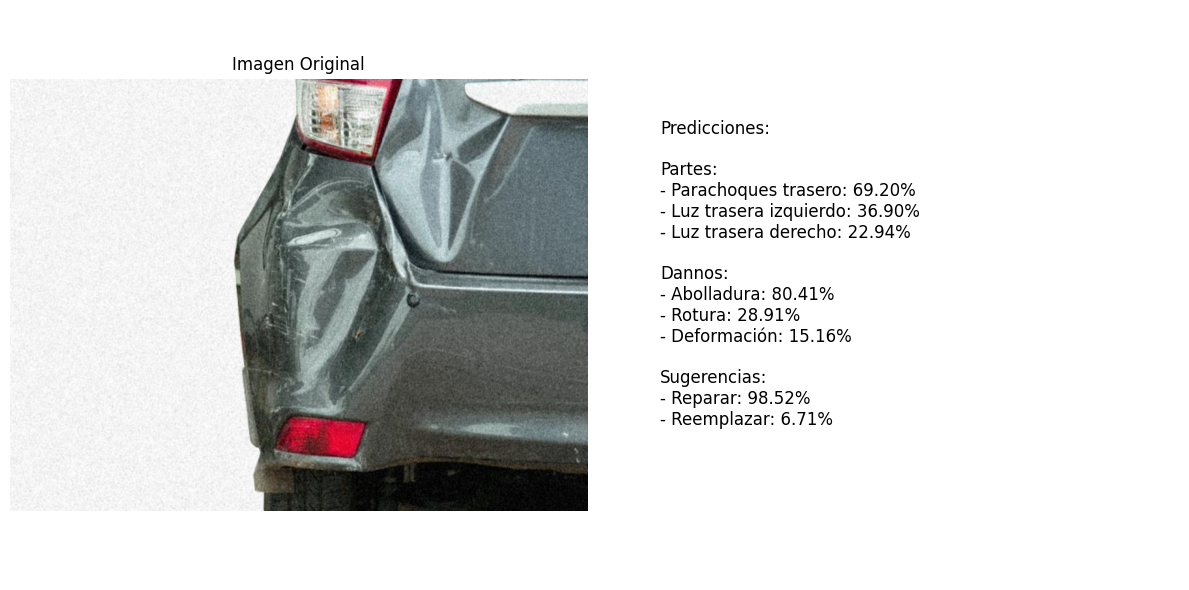

In [18]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

In [19]:
# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

NameError: name 'evaluation_results' is not defined

In [16]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json


---
cargar el modelo ya entrenado

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os

# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

2025-05-11 19:30:53.154381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 19:30:53.154712: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 19:30:53.156591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 19:30:53.161956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747006253.171450  408157 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747006253.17

In [2]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

2025-05-11 19:31:02.971895: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modelo cargado desde final_model_fine_tuned_v2.keras


In [3]:
# Ruta imagen para predecir
image_path = "../data/predecir/golpe_01.jpg"

In [4]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones:")
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
Predicciones:

Partes:
- Rueda: 30.30%
- Parachoques trasero: 23.04%
- Parachoques delantero: 22.91%

Dannos:
- Abolladura: 64.85%
- Rotura: 32.98%
- Desprendimiento: 17.64%

Sugerencias:
- Reparar: 81.13%
- Reemplazar: 34.81%


---